In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split
from torch.utils.data import ConcatDataset

import pywt
from scipy.signal import welch
from scipy.stats import chi2_contingency, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    silhouette_score,
)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap
from imblearn.over_sampling import SMOTE
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import GroupKFold
from collections import Counter

In [5]:
class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True) 
        std[std == 0] = 1e-8  
        
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis
    

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,start_time=16,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz']):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment 
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad
        
        self.start_time=start_time
        self.end_time=int((target_length/12)+self.start_time)

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < self.start_time * 3600 or start_time > self.end_time * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (self.start_time * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count
    

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter settings
latent_dim = 10  # Dimension of the latent space
initial_channels = 128  # Initial number of channels for CNN
start_time=16 #Set initial hour
seq_length = (68 - start_time) * 12  # Number of `5min` windows for 52 hours (624)
batch_size = 32
epochs = 100
alpha = 1e-12  # Adjust KL divergence weight
patience = 10  # Define the number of epochs without improvement before stopping training
padding_method = 'constant'  # Use constant padding
is_augment = False  # Do not use
is_VAEtrain_aug=False # Do not use
num_good_train=1
num_bad_train=1
num_good_test=1
num_bad_test=1
column_names=['ssd','BCI','avgspectent', 'lv_l5']
num_eeg_channels=len(column_names)

# Define dataset folder paths
data_folder = '5min_smoothed_data/'  # Replace with the actual data folder path
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file = 'files_art_ssd_fts_predictions.csv'

# Create EEG dataset (labels are not used when training VAE)
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # Use labels to determine class-based augmentation
    augment=is_augment,  
    num_good=1,
    num_bad=1,
    column_names=column_names
)

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GroupKFold

# —— 0. 设备设置 —— 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# —— 1. 超参数与数据集初始化 —— 
start_time   = 16
seq_length   = (68 - start_time) * 12  # 624 个 5min 窗口
column_names = ['ssd', 'BCI', 'avgspectent', 'lv_l5']
#column_names = ['BCI']
batch_size   = 32
epochs       = 100
n_splits     = 5
learning_rate= 1e-3

# 创建 EEGDataset
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file='files_art_ssd_fts_predictions.csv',
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode='constant',
    use_labels=True,
    augment=False,
    num_good=1,
    num_bad=1,
    column_names=column_names
)

cuda
✅ Loaded 244 valid EEG files (filtered from 244 total)
Good Outcome: 44, Bad Outcome: 200


Loaded X shape = (244, 624, 1), y shape = (244,)
  NaN count in X: 9
  Inf count in X: 0
含 NaN 的样本索引： [ 15 125 132 155 160 165 182 199 230]


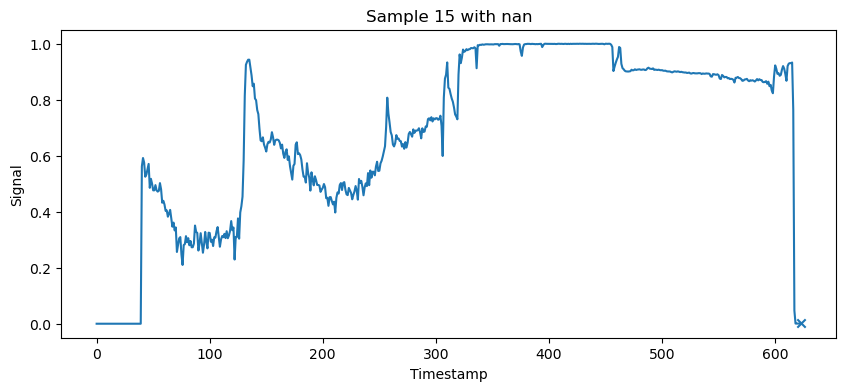

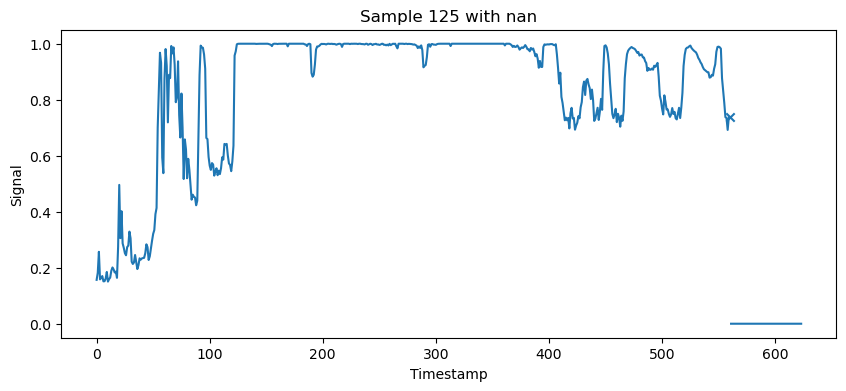

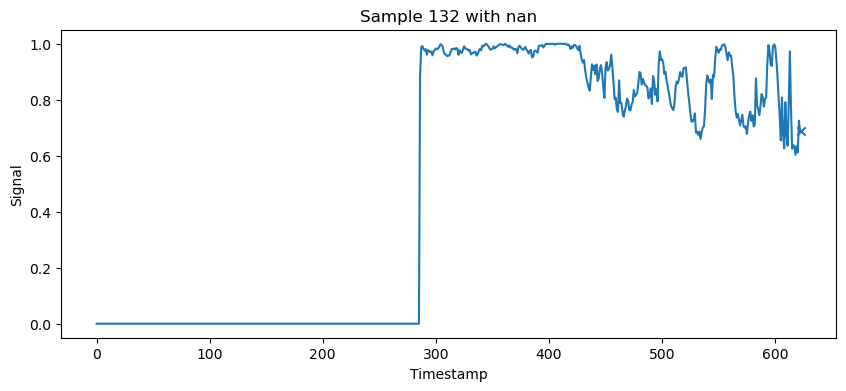

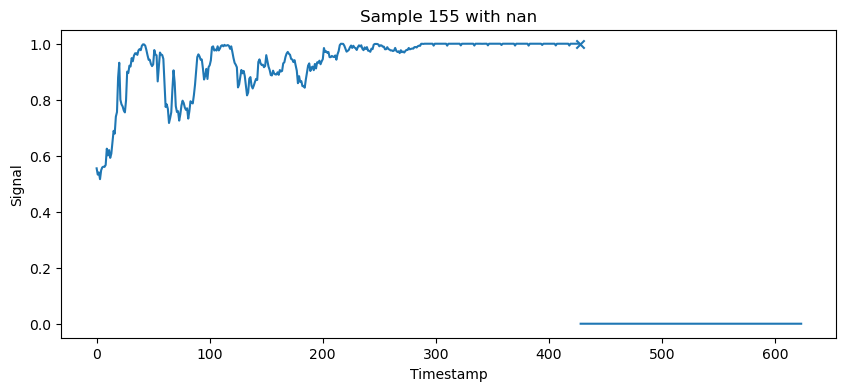

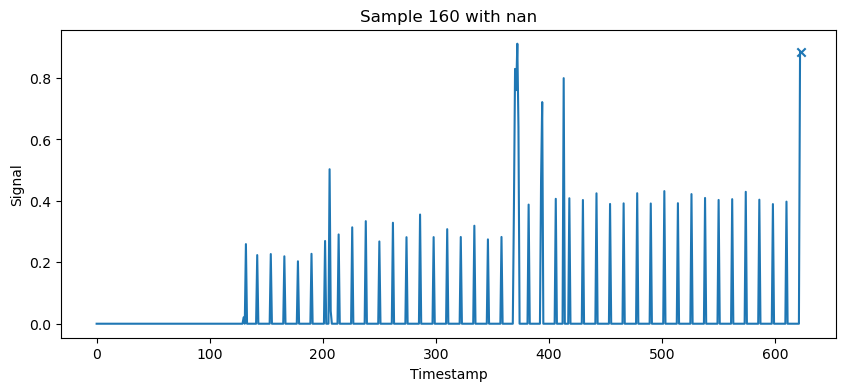

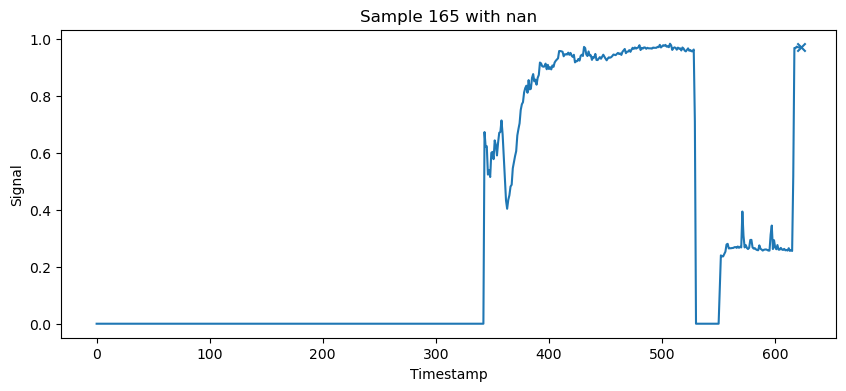

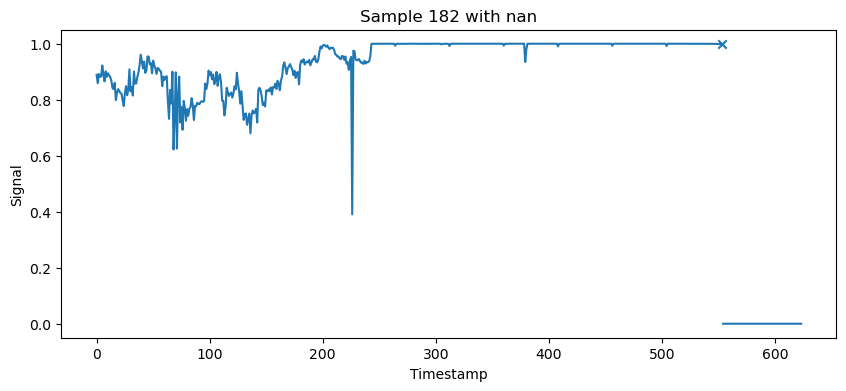

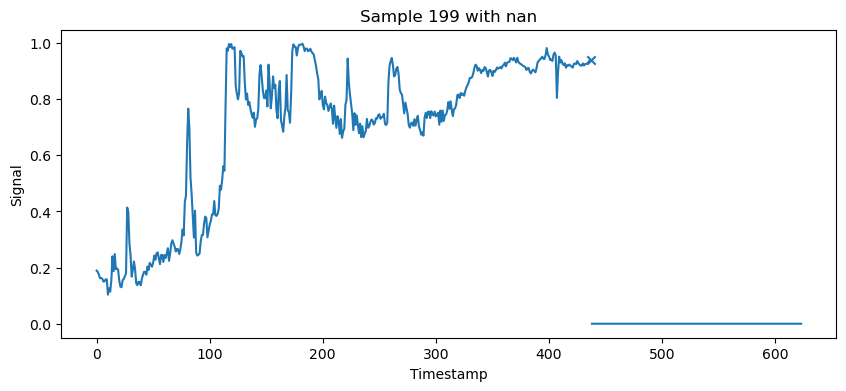

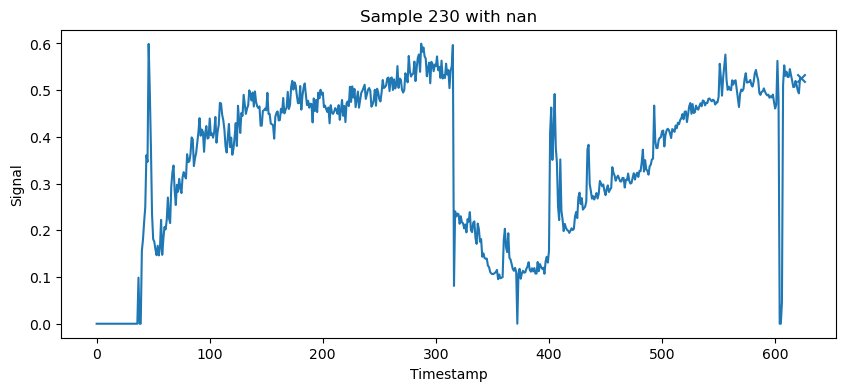

替换后，X 中 NaN 总数： 0
替换后，X 中 Inf 总数： 0


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import GroupKFold
from collections import Counter

# —— 1. 从 EEGDataset 中准备 NumPy 数据 —— 
signals, labels, groups = [], [], []
for idx, label in eeg_dataset.expanded_indices:
    filename, signal = eeg_dataset.valid_files[idx]
    # signal: (n_features, seq_length) -> 转成 (seq_length, n_features)
    signals.append(signal.T)
    labels.append(label)
    groups.append(filename.split('.')[0])  # pat_ID

X = np.stack(signals, dtype=np.float32)   # (n_samples, seq_length, n_features)
y = np.array(labels, dtype=np.float32)    # (n_samples,)
groups = np.array(groups)



print(f"Loaded X shape = {X.shape}, y shape = {y.shape}")
# —— 1.1 检查 X, y 中是否含 NaN 或 Inf —— 
if np.isnan(X).any() or np.isinf(X).any():
    # 打印出具体位置或统计
    print("Warning: X 中存在 NaN 或 Inf！")
    print("  NaN count in X:", np.isnan(X).sum())
    print("  Inf count in X:", np.isinf(X).sum())
    # 根据需求选择：抛出异常/或用 0 填充/或丢弃对应样本
    # raise ValueError("X 中含无效值，请先清洗数据")

if np.isnan(y).any() or np.isinf(y).any():
    print("Warning: y 中存在 NaN 或 Inf！")
    print("  NaN count in y:", np.isnan(y).sum())
    print("  Inf count in y:", np.isinf(y).sum())
    # raise ValueError("y 中含无效值，请先清洗数据")

# 1. 找出含 NaN 的样本索引
nan_idxs = np.unique(np.where(np.isnan(X))[0])
print("含 NaN 的样本索引：", nan_idxs)

# 2. 可视化每个含 NaN 的样本
for idx in nan_idxs:
    ts_data = X[idx]  # (seq_length, n_features)
    seq_len, n_feat = ts_data.shape

    plt.figure(figsize=(10, 4))
    for f in range(n_feat):
        series = ts_data[:, f]
        plt.plot(series)  # 原始序列
        mask = np.isnan(series)
        positions = np.where(mask)[0]
        # 用邻近有效点的值来定位标记高度
        y_vals = []
        for p in positions:
            if p > 0 and not np.isnan(series[p-1]):
                y_vals.append(series[p-1])
            elif p < seq_len-1 and not np.isnan(series[p+1]):
                y_vals.append(series[p+1])
            else:
                y_vals.append(0.0)
        plt.scatter(positions, y_vals, marker='x')  # 标记 NaN 位置

    plt.title(f"Sample {idx} with nan")
    plt.xlabel("Timestamp")
    plt.ylabel("Signal")
    plt.show()



# 3. 将所有 NaN 和 Inf 替换为 0
#    nan_to_num 会同时处理 NaN、正无穷、负无穷
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# 4. 再次验证
print("替换后，X 中 NaN 总数：", np.isnan(X).sum())
print("替换后，X 中 Inf 总数：", np.isinf(X).sum())

In [9]:
# —— 2. 设置交叉验证和保存结果的容器 —— 
cv        = GroupKFold(n_splits=5)
cvscores  = []
auc_scores= []
preds_all = []

# —— 3. 在每个 fold 中重新构建模型、训练、评估 —— 
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))
    
    # —— 3.1 定义 Keras 模型 —— 
    model = Sequential([
        LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(12, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    # —— 3.2 训练 —— 
    model.fit(
        X_tr, y_tr,
        batch_size=8,
        epochs=20,    # 可调整
        verbose=2
    )
    
    # —— 3.3 评估 —— 
    scores = model.evaluate(X_te, y_te, verbose=0)
    acc    = scores[1] * 100
    auc    = scores[2] * 100
    print(f"Accuracy: {acc:.2f}%, AUC: {auc:.2f}%")
    
    # —— 3.4 保存结果 —— 
    cvscores.append(acc)
    auc_scores.append(auc)
    
    # —— 3.5 预测并存储所有 fold 的输出 —— 
    preds = model.predict(X_te, verbose=0).flatten()
    preds_all.extend(preds)

# —— 4. 汇总所有 fold —— 
print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")


--- Fold 1 ---
 train balance: Counter({0.0: 162, 1.0: 33})
  test balance: Counter({0.0: 38, 1.0: 11})
Epoch 1/20


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 - 7s - 268ms/step - accuracy: 0.7897 - auc: 0.5286 - loss: 0.5334
Epoch 2/20
25/25 - 4s - 165ms/step - accuracy: 0.8308 - auc: 0.4315 - loss: 0.4803
Epoch 3/20
25/25 - 5s - 203ms/step - accuracy: 0.8308 - auc: 0.5635 - loss: 0.4537
Epoch 4/20
25/25 - 4s - 161ms/step - accuracy: 0.8308 - auc: 0.4691 - loss: 0.4712
Epoch 5/20
25/25 - 5s - 213ms/step - accuracy: 0.8308 - auc: 0.4476 - loss: 0.4707
Epoch 6/20
25/25 - 5s - 207ms/step - accuracy: 0.8308 - auc: 0.4845 - loss: 0.4638
Epoch 7/20
25/25 - 5s - 207ms/step - accuracy: 0.8308 - auc: 0.5372 - loss: 0.4565
Epoch 8/20
25/25 - 4s - 167ms/step - accuracy: 0.8308 - auc: 0.4907 - loss: 0.4649
Epoch 9/20
25/25 - 5s - 211ms/step - accuracy: 0.8308 - auc: 0.4872 - loss: 0.4670
Epoch 10/20
25/25 - 4s - 169ms/step - accuracy: 0.8308 - auc: 0.6705 - loss: 0.4405
Epoch 11/20
25/25 - 4s - 168ms/step - accuracy: 0.8308 - auc: 0.4472 - loss: 0.4682
Epoch 12/20
25/25 - 5s - 206ms/step - accuracy: 0.8308 - auc: 0.4670 - loss: 0.4657
Epoch 13/20


In [10]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import numpy as np
import tensorflow as tf
from collections import Counter

# 假设 X, y, groups 都已准备好
cv = GroupKFold(n_splits=5)
cvscores, auc_scores, preds_all = [], [], []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))
    
    # 计算类别权重
    classes = np.unique(y_tr)
    weights = compute_class_weight('balanced', classes=classes, y=y_tr)
    class_weight = dict(zip(classes, weights))
    print(" class weights:", class_weight)
    
    # 定义模型
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(12),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    # 训练时传入 class_weight
    model.fit(
        X_tr, y_tr,
        batch_size=8,
        epochs=20,
        verbose=2,
        class_weight=class_weight
    )
    
    # 评估
    loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
    print(f"Accuracy: {acc*100:.2f}%, AUC: {auc*100:.2f}%")
    cvscores.append(acc*100)
    auc_scores.append(auc*100)
    
    preds_all.extend(model.predict(X_te).flatten())

# 汇总
print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")



--- Fold 1 ---
 train balance: Counter({0.0: 162, 1.0: 33})
  test balance: Counter({0.0: 38, 1.0: 11})
 class weights: {0.0: 0.6018518518518519, 1.0: 2.9545454545454546}
Epoch 1/20
25/25 - 7s - 284ms/step - accuracy: 0.4051 - auc: 0.5511 - loss: 0.6921
Epoch 2/20
25/25 - 5s - 209ms/step - accuracy: 0.3590 - auc: 0.5252 - loss: 0.6935
Epoch 3/20
25/25 - 5s - 210ms/step - accuracy: 0.3897 - auc: 0.5119 - loss: 0.6952
Epoch 4/20
25/25 - 4s - 175ms/step - accuracy: 0.3949 - auc: 0.5865 - loss: 0.6871
Epoch 5/20
25/25 - 5s - 209ms/step - accuracy: 0.3744 - auc: 0.4846 - loss: 0.6966
Epoch 6/20
25/25 - 5s - 181ms/step - accuracy: 0.4410 - auc: 0.4884 - loss: 0.6969
Epoch 7/20
25/25 - 4s - 176ms/step - accuracy: 0.4308 - auc: 0.5614 - loss: 0.6907
Epoch 8/20
25/25 - 5s - 210ms/step - accuracy: 0.4000 - auc: 0.5643 - loss: 0.6902
Epoch 9/20
25/25 - 5s - 206ms/step - accuracy: 0.4000 - auc: 0.5266 - loss: 0.6924
Epoch 10/20
25/25 - 5s - 204ms/step - accuracy: 0.4000 - auc: 0.5606 - loss: 0.69

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# 假设 X, y, groups 已经准备好
cv = GroupKFold(n_splits=5)
cvscores, auc_scores = [], []

# 可选：定义 Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_t * tf.pow(1 - p_t, gamma) * bce
    return loss_fn

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))

    # —— 1. 过采样少数类 —— 
    n_s, seq_len, n_feat = X_tr.shape
    X_flat = X_tr.reshape(n_s, -1)
    ros = RandomOverSampler(random_state=42)
    X_res_flat, y_res = ros.fit_resample(X_flat, y_tr)
    X_res = X_res_flat.reshape(-1, seq_len, n_feat)
    print(" after oversampling:", Counter(y_res))

    # —— 2. 定义模型（示例用双向 LSTM） —— 
    model = Sequential([
        Input(shape=(seq_len, n_feat)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        LSTM(12),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss=focal_loss(),  # 或者用 'binary_crossentropy'
        optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # —— 3. 训练 —— 
    model.fit(
        X_res, y_res,
        batch_size=8,
        epochs=20,
        verbose=2
    )

    # —— 4. 评估 —— 
    loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
    print(f"Accuracy: {acc*100:.2f}%, AUC: {auc*100:.2f}%")
    cvscores.append(acc*100)
    auc_scores.append(auc*100)

print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")



--- Fold 1 ---
 train balance: Counter({0.0: 162, 1.0: 33})
  test balance: Counter({0.0: 38, 1.0: 11})
 after oversampling: Counter({0.0: 162, 1.0: 162})
Epoch 1/20
41/41 - 12s - 302ms/step - accuracy: 0.5123 - auc: 0.4412 - loss: 0.0852
Epoch 2/20
41/41 - 7s - 182ms/step - accuracy: 0.5000 - auc: 0.5064 - loss: 0.0816
Epoch 3/20
41/41 - 7s - 180ms/step - accuracy: 0.5000 - auc: 0.4854 - loss: 0.0801
Epoch 4/20
41/41 - 10s - 247ms/step - accuracy: 0.5000 - auc: 0.4183 - loss: 0.0805
Epoch 5/20
41/41 - 7s - 178ms/step - accuracy: 0.5000 - auc: 0.4203 - loss: 0.0800
Epoch 6/20
41/41 - 10s - 253ms/step - accuracy: 0.5000 - auc: 0.4404 - loss: 0.0786
Epoch 7/20
41/41 - 7s - 176ms/step - accuracy: 0.5000 - auc: 0.4411 - loss: 0.0784
Epoch 8/20
41/41 - 7s - 175ms/step - accuracy: 0.5000 - auc: 0.5076 - loss: 0.0753
Epoch 9/20
41/41 - 10s - 252ms/step - accuracy: 0.5000 - auc: 0.4117 - loss: 0.0781
Epoch 10/20
41/41 - 7s - 176ms/step - accuracy: 0.5000 - auc: 0.5002 - loss: 0.0745
Epoch 11/